# Breast Cancer Detection - CRISP-DM Project

## 1. Business Understanding
**Objective:** Predict malignant vs benign breast tumors from the provided dataset (`data.csv`).
**Success Criteria:** High Recall for Malignant class (minimize false negatives) and high ROC-AUC.

## 2. Data Understanding

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                            accuracy_score, recall_score, precision_score, f1_score, 
                            precision_recall_curve, make_scorer)
from imblearn.over_sampling import SMOTE
import joblib
import os
import json

sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

In [17]:
# Chargement des données
df = pd.read_csv('data.csv')
print(f'Dimensions: {df.shape}')
print(f'Valeurs manquantes: {df.isnull().sum().sum()}')
print(f'Distribution: {df["diagnosis"].value_counts().to_dict()}')
df.head()

Dimensions: (569, 33)
Valeurs manquantes: 569
Distribution: {'B': 357, 'M': 212}


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [18]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


### 2.1 Dataset Overview


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [20]:
df.isnull().sum().sum()

np.int64(569)

### 2.2 Feature Structure Analysis

**Understanding the 30 Features:**

The dataset contains **30 features** derived from **10 base measurements**, each with **3 statistical aggregations**:

- **Mean (_mean)**: Average value across all cells in the image
- **Standard Error (_se)**: Standard error of the mean (measurement variability)
- **Worst (_worst)**: Largest (worst) value found among all cells

**Base Features (10):**
1. radius
2. texture  
3. perimeter
4. area
5. smoothness
6. compactness
7. concavity
8. concave points
9. symmetry
10. fractal_dimension

**Why these statistics matter:**
- **Mean**: Captures typical/representative cell characteristics
- **SE**: Indicates consistency/variability (high SE = more heterogeneous tumor)
- **Worst**: Captures the most extreme/malignant characteristics (often most predictive)

**Note:** We don't have raw pixel-level data - these are already aggregated statistics from image analysis.


In [21]:
# Check for missing values

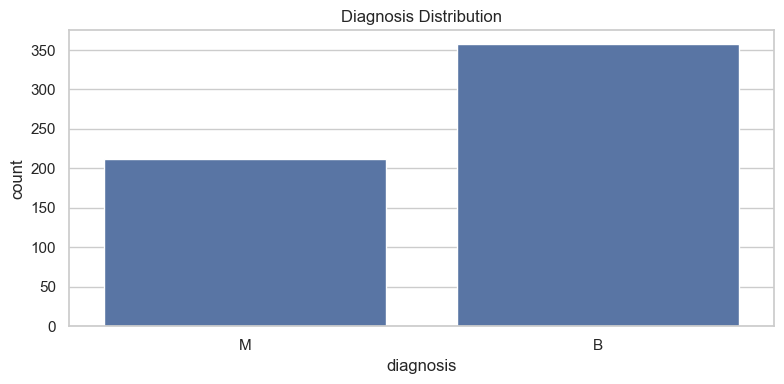

In [22]:
os.makedirs('results/plots', exist_ok=True)

plt.figure(figsize=(8, 4))
sns.countplot(x='diagnosis', data=df)
plt.title('Diagnosis Distribution')
plt.tight_layout()
plt.savefig('results/plots/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

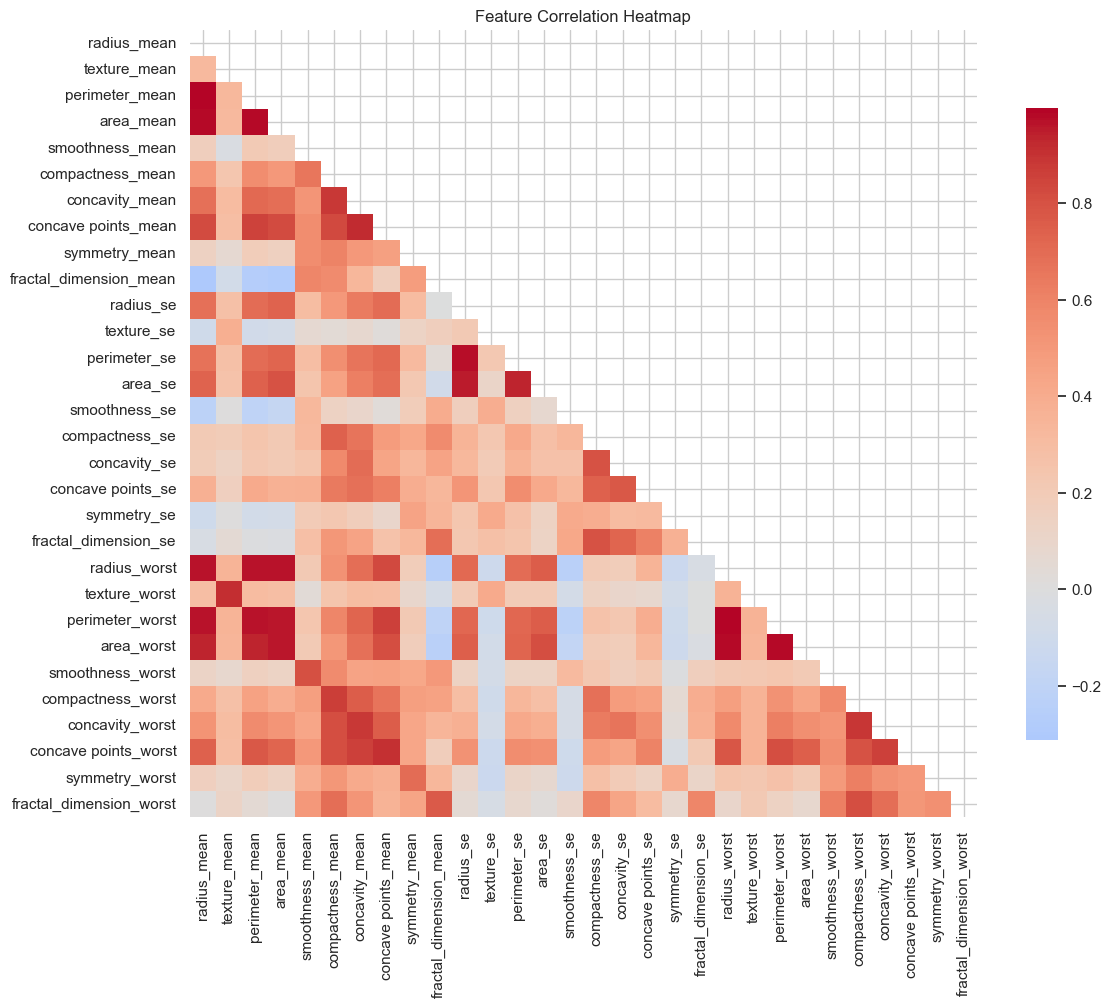

In [23]:
numeric_df = df.select_dtypes(include=[np.number]).drop(['id','Unnamed: 32'], axis=1, errors='ignore')
corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('results/plots/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Data Preparation

### 3.1 Data Cleaning

In [24]:
# Nettoyage des données: supprimer colonnes inutiles
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# Encoder la variable cible (B=0, M=1)
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

# Séparer les features et la variable cible
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Division des données: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Équilibrer les classes avec SMOTE (85% de la classe majoritaire)
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.85).fit_resample(X_train, y_train)

# Normalisation des features (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 4. Modeling

In [25]:
# Configuration de la validation croisée
os.makedirs('results', exist_ok=True)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=1)

# Définition des modèles avec hyperparamètres du papier de recherche (Table 1)
models = {
    'MLP': MLPClassifier(
        hidden_layer_sizes=(500, 500, 500),  # Architecture: 3 couches de 500 neurones
        learning_rate_init=0.01,             # Taux d'apprentissage: 1e-2
        max_iter=3000,                        # Nombre maximum d'itérations: 3000
        batch_size=128,                       # Taille du batch: 128
        alpha=0.05,                           # Régularisation L2 pour réduire l'overfitting
        early_stopping=True,                  # Arrêt anticipé si pas d'amélioration
        validation_fraction=0.1,             # 10% des données pour validation interne
        n_iter_no_change=10,                  # Arrêt après 10 itérations sans amélioration
        random_state=42,
        verbose=0                             # Pas de sortie verbeuse
    ),
    'Linear Regression': LogisticRegression(
        max_iter=3000,
        random_state=42
    ),
    'Softmax Regression': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=3000,
        random_state=42
    ),
    'SVM': SVC(
        C=5.0,                                # Paramètre de régularisation C=5
        kernel='rbf',
        probability=True,
        max_iter=3000,
        random_state=42
    ),
    'L1-NN': KNeighborsClassifier(n_neighbors=5, p=1),  # Distance Manhattan (L1)
    'L2-NN': KNeighborsClassifier(n_neighbors=5, p=2)   # Distance Euclidienne (L2)
}

# Entraînement et évaluation de tous les modèles
all_results = {}

for name, model in models.items():
    print(f"Entraînement {name}...")
    
    # Entraîner le modèle
    model.fit(X_train_scaled, y_train_balanced)
    
    # Validation croisée
    cv_roc = cross_val_score(model, X_train_scaled, y_train_balanced, cv=cv, scoring='roc_auc')
    cv_recall = cross_val_score(model, X_train_scaled, y_train_balanced, cv=cv, scoring=recall_scorer)
    cv_acc = cross_val_score(model, X_train_scaled, y_train_balanced, cv=cv, scoring='accuracy')
    
    # Prédictions sur l'ensemble de validation
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    y_val_pred = model.predict(X_val_scaled)
    
    # Stocker les résultats
    all_results[name] = {
        'model': model,
        'CV_ROC_AUC_mean': float(cv_roc.mean()),
        'CV_ROC_AUC_std': float(cv_roc.std()),
        'CV_Recall_mean': float(cv_recall.mean()),
        'CV_Recall_std': float(cv_recall.std()),
        'CV_Accuracy_mean': float(cv_acc.mean()),
        'CV_Accuracy_std': float(cv_acc.std()),
        'Val_Accuracy': float(accuracy_score(y_val, y_val_pred)),
        'Val_ROC_AUC': float(roc_auc_score(y_val, y_val_proba)) if y_val_proba is not None else None,
        'Val_Recall': float(recall_score(y_val, y_val_pred, pos_label=1)),
        'Val_Precision': float(precision_score(y_val, y_val_pred, pos_label=1)),
        'Val_F1': float(f1_score(y_val, y_val_pred, pos_label=1))
    }
    
    # Sauvegarder les résultats individuels
    with open(f'results/{name.lower().replace(" ", "_").replace("-", "_")}_results.json', 'w') as f:
        json.dump({
            'model_name': name,
            'cross_validation': {
                'roc_auc': {'mean': all_results[name]['CV_ROC_AUC_mean'], 'std': all_results[name]['CV_ROC_AUC_std']},
                'recall': {'mean': all_results[name]['CV_Recall_mean'], 'std': all_results[name]['CV_Recall_std']},
                'accuracy': {'mean': all_results[name]['CV_Accuracy_mean'], 'std': all_results[name]['CV_Accuracy_std']}
            },
            'validation_set': {
                'accuracy': all_results[name]['Val_Accuracy'],
                'roc_auc': all_results[name]['Val_ROC_AUC'],
                'recall': all_results[name]['Val_Recall'],
                'precision': all_results[name]['Val_Precision'],
                'f1_score': all_results[name]['Val_F1']
            }
        }, f, indent=2)

# Utiliser MLP comme modèle principal pour les analyses suivantes
model = all_results['MLP']['model']
results = {k: v for k, v in all_results['MLP'].items() if k != 'model'}

Entraînement MLP...
Entraînement Linear Regression...


c:\Users\Hazem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Hazem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Hazem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, 

Entraînement Softmax Regression...


c:\Users\Hazem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Hazem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Hazem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, 

Entraînement SVM...
Entraînement L1-NN...
Entraînement L2-NN...


In [26]:
# Résumé des modèles - Validation
print("Résumé des modèles (Validation):")
for name, res in all_results.items():
    print(f"{name}: Accuracy={res['Val_Accuracy']:.4f}, ROC-AUC={res['Val_ROC_AUC']:.4f}, Recall={res['Val_Recall']:.4f}")

# Sauvegarder les résultats de comparaison
comparison_data = []
for name, res in all_results.items():
    comparison_data.append({
        'Model': name,
        'CV_ROC_AUC': f"{res['CV_ROC_AUC_mean']:.4f} ± {res['CV_ROC_AUC_std']:.4f}",
        'Val_Accuracy': res['Val_Accuracy'],
        'Val_ROC_AUC': res['Val_ROC_AUC'],
        'Val_Recall': res['Val_Recall'],
        'Val_Precision': res['Val_Precision'],
        'Val_F1': res['Val_F1']
    })

with open('results/model_comparison.json', 'w') as f:
    json.dump(comparison_data, f, indent=2)


Résumé des modèles (Validation):
MLP: Accuracy=0.9737, ROC-AUC=0.9951, Recall=0.9767
Linear Regression: Accuracy=0.9737, ROC-AUC=0.9957, Recall=0.9767
Softmax Regression: Accuracy=0.9737, ROC-AUC=0.9954, Recall=0.9767
SVM: Accuracy=0.9737, ROC-AUC=0.9967, Recall=0.9767
L1-NN: Accuracy=0.9737, ROC-AUC=0.9961, Recall=0.9302
L2-NN: Accuracy=0.9649, ROC-AUC=0.9967, Recall=0.9535


## 5. Evaluation

### 5.1 Test Set Evaluation


In [27]:
# Évaluation sur l'ensemble de test pour tous les modèles
test_results_all = {}

for name, res in all_results.items():
    model = res['model']
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculer les probabilités si le modèle le supporte
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    else:
        y_test_proba = None
        roc_auc = None
    
    # Stocker les métriques de test
    test_results_all[name] = {
        'accuracy': float(accuracy_score(y_test, y_test_pred)),
        'roc_auc': float(roc_auc) if roc_auc is not None else None,
        'recall': float(recall_score(y_test, y_test_pred, pos_label=1)),
        'precision': float(precision_score(y_test, y_test_pred, pos_label=1)),
        'f1_score': float(f1_score(y_test, y_test_pred, pos_label=1))
    }

# Utiliser les résultats MLP pour les analyses suivantes
y_test_proba = all_results['MLP']['model'].predict_proba(X_test_scaled)[:, 1]
y_test_pred = all_results['MLP']['model'].predict(X_test_scaled)
test_metrics = test_results_all['MLP']

results.update({
    'Test_Accuracy': test_metrics['accuracy'],
    'Test_ROC_AUC': test_metrics['roc_auc'],
    'Test_Recall': test_metrics['recall'],
    'Test_Precision': test_metrics['precision'],
    'Test_F1': test_metrics['f1_score']
})

# Sauvegarder les résultats de test
with open('results/test_results.json', 'w') as f:
    json.dump(test_results_all, f, indent=2)

### 5.2 Confusion Matrix


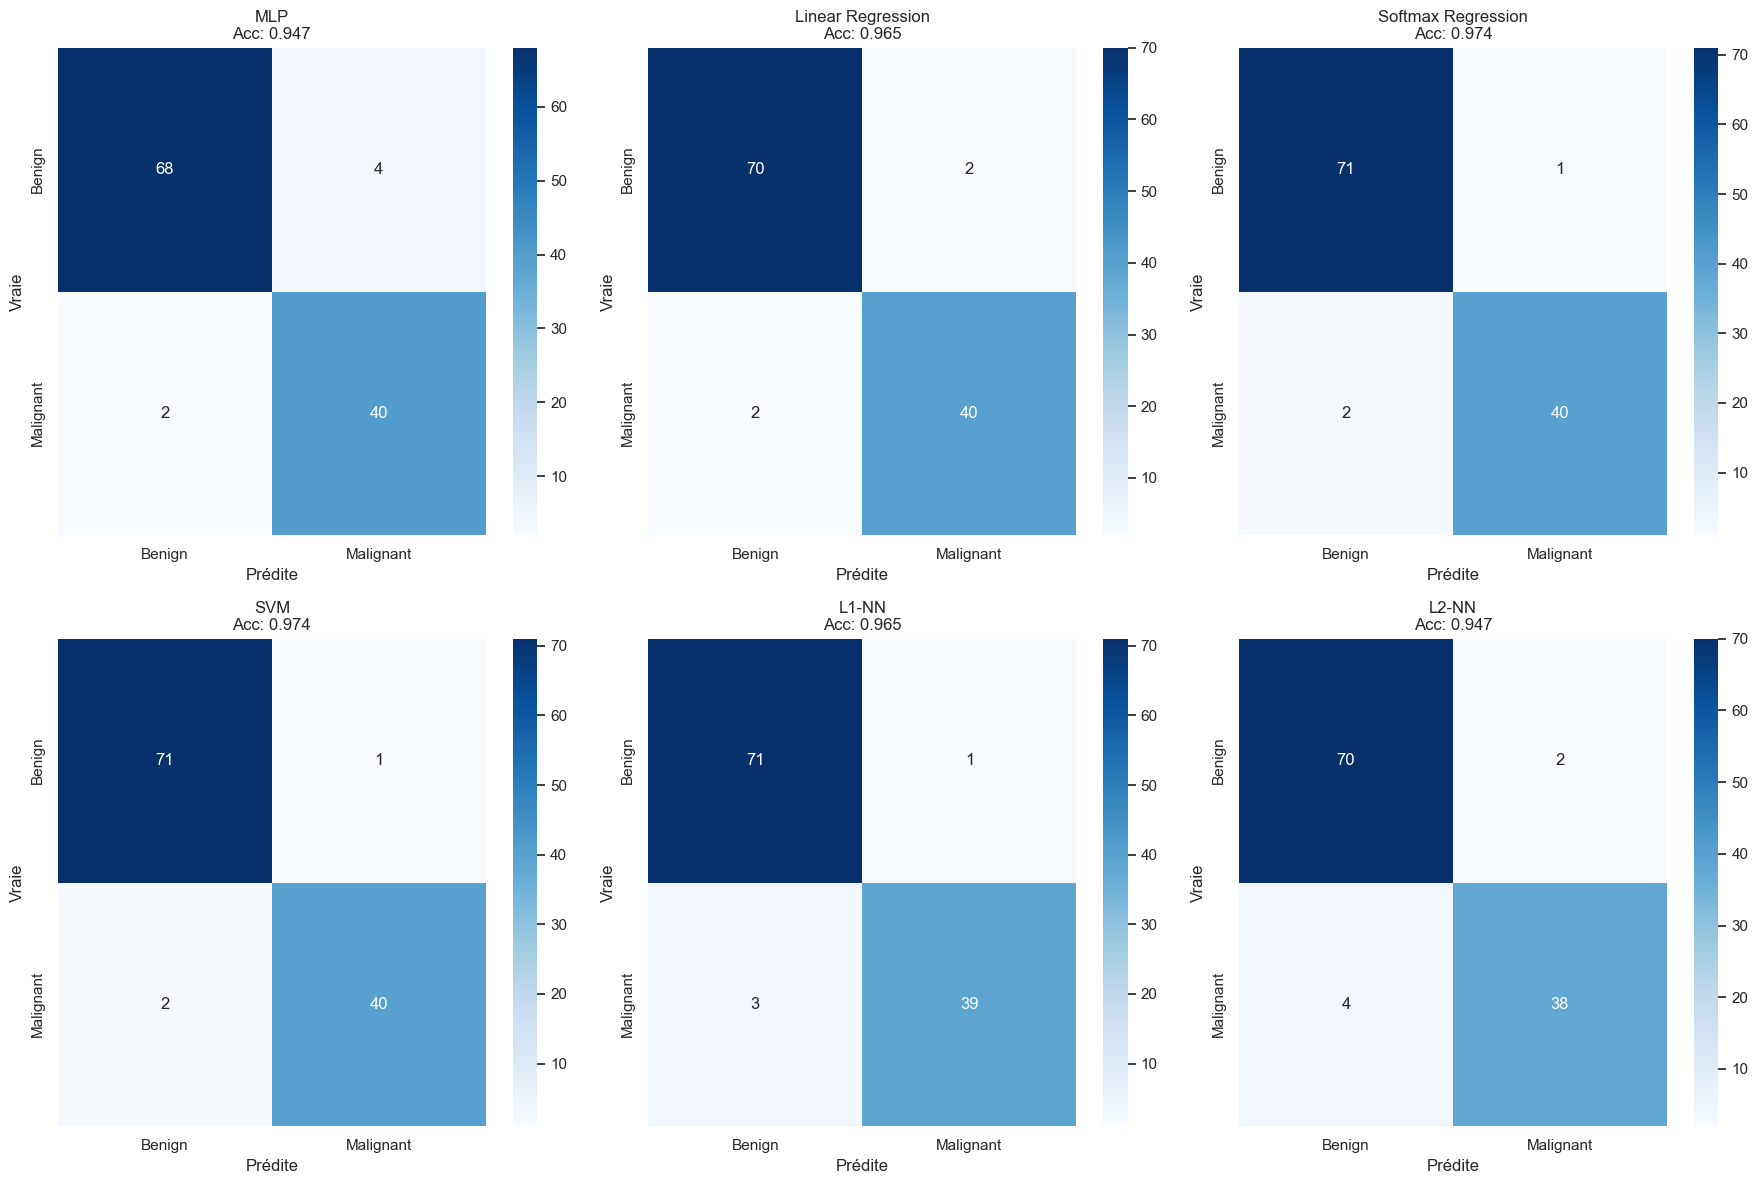

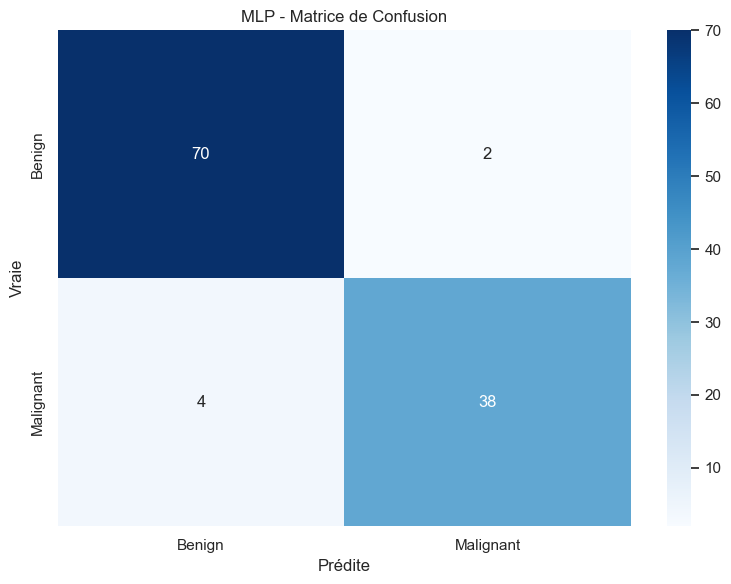

In [28]:
# Matrices de confusion pour tous les modèles
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, res) in enumerate(all_results.items()):
    model = res['model']
    y_test_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_test_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    axes[idx].set_title(f'{name}\nAcc: {test_results_all[name]["accuracy"]:.3f}')
    axes[idx].set_ylabel('Vraie')
    axes[idx].set_xlabel('Prédite')

plt.tight_layout()
plt.savefig('results/plots/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# Matrice de confusion MLP (modèle principal)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('MLP - Matrice de Confusion')
plt.ylabel('Vraie')
plt.xlabel('Prédite')
plt.tight_layout()
plt.savefig('results/plots/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


### 5.3 ROC Curve


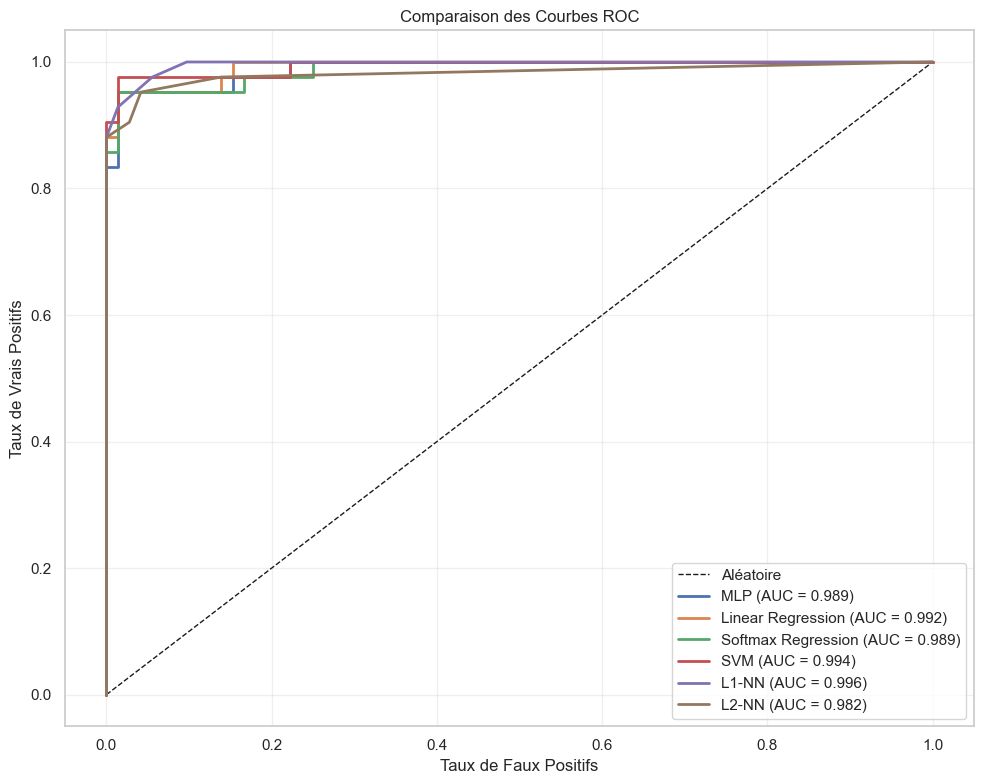

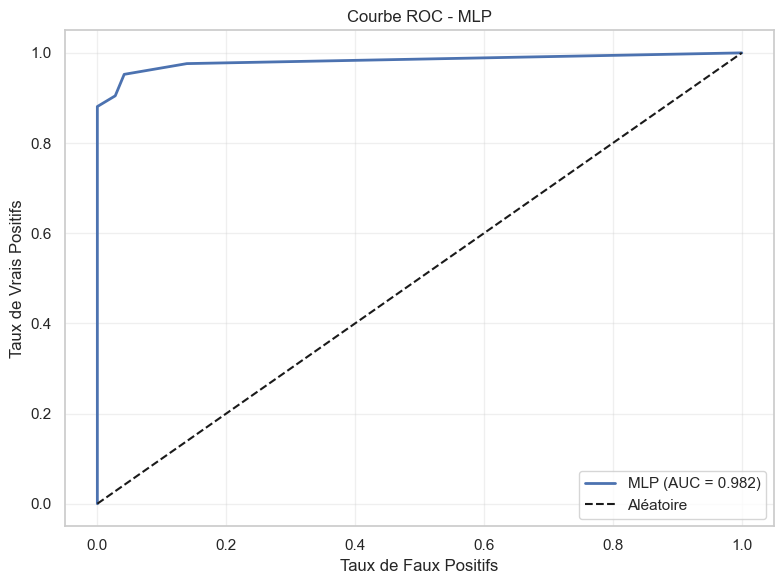

In [29]:
# Courbes ROC pour tous les modèles
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire', linewidth=1)

for name, res in all_results.items():
    model = res['model']
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = roc_auc_score(y_test, y_test_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})", linewidth=2)

plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Comparaison des Courbes ROC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/plots/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Courbe ROC MLP (modèle principal)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"MLP (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - MLP')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/plots/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


### 5.4 Results Summary


In [30]:
# Résumé final des résultats sur l'ensemble de test
print("Résumé final - Ensemble de test:")
print(f"{'Modèle':<20} {'Accuracy':<12} {'ROC-AUC':<12} {'Recall':<12} {'Precision':<12} {'F1':<12}")

for name, metrics in test_results_all.items():
    acc = f"{metrics['accuracy']:.4f}"
    auc = f"{metrics['roc_auc']:.4f}" if metrics['roc_auc'] else "N/A"
    recall = f"{metrics['recall']:.4f}"
    precision = f"{metrics['precision']:.4f}"
    f1 = f"{metrics['f1_score']:.4f}"
    print(f"{name:<20} {acc:<12} {auc:<12} {recall:<12} {precision:<12} {f1:<12}")

# Sauvegarder le résumé
summary_data = []
for name, metrics in test_results_all.items():
    summary_data.append({
        'Model': name,
        'Test_Accuracy': metrics['accuracy'],
        'Test_ROC_AUC': metrics['roc_auc'],
        'Test_Recall': metrics['recall'],
        'Test_Precision': metrics['precision'],
        'Test_F1': metrics['f1_score']
    })

with open('results/results_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2)

Résumé final - Ensemble de test:
Modèle               Accuracy     ROC-AUC      Recall       Precision    F1          
MLP                  0.9474       0.9894       0.9524       0.9091       0.9302      
Linear Regression    0.9649       0.9921       0.9524       0.9524       0.9524      
Softmax Regression   0.9737       0.9888       0.9524       0.9756       0.9639      
SVM                  0.9737       0.9937       0.9524       0.9756       0.9639      
L1-NN                0.9649       0.9962       0.9286       0.9750       0.9512      
L2-NN                0.9474       0.9823       0.9048       0.9500       0.9268      
